### **1. Load Libraries**

In [1]:
import src.util as utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from datetime import datetime
from tqdm import tqdm
import yaml
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import hashlib

### **2. Load Config File**

In [2]:
config = utils.load_config()

### **3. Load Train, Valid, Test**

In [3]:
def load_train_feng(params: dict) -> pd.DataFrame:
    # Load train set
    x_train = utils.pickle_load(params["train_feng_set_path"][0])
    y_train = utils.pickle_load(params["train_feng_set_path"][1])

    return x_train, y_train

def load_valid(params: dict) -> pd.DataFrame:
    # Load valid set
    x_valid = utils.pickle_load(params["valid_feng_set_path"][0])
    y_valid = utils.pickle_load(params["valid_feng_set_path"][1])

    return x_valid, y_valid

def load_test(params: dict) -> pd.DataFrame:
    # Load tets set
    x_test = utils.pickle_load(params["test_feng_set_path"][0])
    y_test = utils.pickle_load(params["test_feng_set_path"][1])

    return x_test, y_test

In [4]:
x_train, y_train = load_train_feng(config)
x_valid, y_valid = load_valid(config)
x_test, y_test = load_test(config)

### **4. Create Log Template**

In [5]:
# Create training log function

def time_stamp():
    return datetime.now()

def create_log_template():
    logger = {
        "model_name" : [],
        "model_uid" : [],
        "training_time" : [],
        "training_date" : [],
        "performance" : [],
        "f1_avg" : [],
        "data_configurations" : [],
    }

    return logger

In [6]:
# Create training log updater

def training_log_updater(current_log, log_path):
    current_log = current_log.copy()

    log_path = config["training_log_path"]

    try:
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    except FileNotFoundError as ffe:
        with open(log_path, "w") as file:
            file.write("[]")
        file.close()
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    
    last_log.append(current_log)

    with open(log_path, "w") as file:
        json.dump(last_log, file)
        file.close()

    return last_log

### **5. Training Model**

5.1. Create Model Object

In [7]:
# Base Model
svm_baseline = SVC()
rf_baseline = RandomForestClassifier()
knn_baseline = KNeighborsClassifier()

In [8]:
list_of_model = {
    "smote" : [
        { "model_name": svm_baseline.__class__.__name__, "model_object": svm_baseline, "model_uid": ""},
        { "model_name": rf_baseline.__class__.__name__, "model_object": rf_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""}
        ]
    }

5.2. Training Model

In [9]:
# Function to fit model and logging to training log
def train_eval_model(list_of_model, prefix_model_name, x_train, y_train, data_configuration_name, x_valid, y_valid, log_path):

    list_of_model = copy.deepcopy(list_of_model)
    logger = create_log_template()

    for model in tqdm(list_of_model):    
        model_name = prefix_model_name + "-" + model["model_name"]

        start_time = time_stamp()
        model["model_object"].fit(x_train, y_train)
        finished_time = time_stamp()

        elapsed_time = finished_time - start_time
        elapsed_time = elapsed_time.total_seconds()

        y_pred = model["model_object"].predict(x_valid)
        performance = classification_report(y_valid, y_pred, output_dict = True)

        plain_id = str(start_time) + str(finished_time)
        chiper_id = hashlib.md5(plain_id.encode()).hexdigest()

        model["model_uid"] = chiper_id

        logger["model_name"].append(model_name)
        logger["model_uid"].append(chiper_id)
        logger["training_time"].append(elapsed_time)
        logger["training_date"].append(str(start_time))
        logger["performance"].append(performance)
        logger["f1_avg"].append(performance['macro avg']["f1-score"])
        logger["data_configurations"].append(data_configuration_name)

    training_log = training_log_updater(logger, log_path)

    return training_log, list_of_model

5.2.1. Baseline Model - SMOTE

In [10]:
training_log, list_of_model_sm = train_eval_model(
    list_of_model["smote"],
    "baseline_model",
    x_train,
    y_train,
    "smote",
    x_valid,
    y_valid,
    "log/training_log.json"
)

 67%|██████▋   | 2/3 [00:00<00:00,  2.00it/s]c:\Users\Mint_01\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


In [11]:
list_of_model["smote"] = copy.deepcopy(list_of_model_sm)

5.3. Best Performance

In [12]:
# Function to convert training log.json to dataframe
def training_log_to_df(training_log):
    training_res = pd.DataFrame()

    for log in tqdm(training_log):
        training_res = pd.concat([training_res, pd.DataFrame(log)])
    
    training_res.sort_values(["f1_avg", "training_time"], ascending = [False, True], inplace = True)
    training_res.reset_index(inplace = True, drop = True)
    
    return training_res

In [13]:
training_res = training_log_to_df(training_log)

100%|██████████| 1/1 [00:00<00:00, 499.62it/s]


In [14]:
training_res

,model_name,model_uid,training_time,training_date,performance,f1_avg,data_configurations
0,baseline_model-RandomForestClassifier,169a0d4df22dabe960dba082a0d0d33b,0.554969,2023-09-05 18:13:12.124864,"{'0': {'precision': 0.7033333333333334, 'recal...",0.618682,smote
1,baseline_model-SVC,0f09ecbbf1b24e019ad1c184cc28c2b9,0.315032,2023-09-05 18:13:11.720834,"{'0': {'precision': 0.7126865671641791, 'recal...",0.611630,smote
2,baseline_model-KNeighborsClassifier,c52495e6d2a89e046d6efc727e49de4e,0.004968,2023-09-05 18:13:12.694864,"{'0': {'precision': 0.6974169741697417, 'recal...",0.596205,smote


In [15]:
# Function to get the best model out of 3 model
def get_best_model(training_log_df, list_of_model):
    model_object = None

    best_model_info = training_log_df.sort_values(["f1_avg", "training_time"], ascending = [False, True]).iloc[0]
    
    for configuration_data in list_of_model:
        for model_data in list_of_model[configuration_data]:
            if model_data["model_uid"] == best_model_info["model_uid"]:
                model_object = model_data["model_object"]
                break
    
    if model_object == None:
        raise RuntimeError("The best model not found in your list of model.")
    
    return model_object
    

In [16]:
model = get_best_model(training_res, list_of_model)

In [17]:
model

RandomForestClassifier()

Best model is **Random Forest Classifier**

### **6. Hyperparameter Tuning**

In [18]:
# Random Forest parameters

dist_params_rf = {
        "criterion" : ["gini", "entropy"],
        "n_estimators" : [10, 20, 30, 50, 100, 500],
        "min_samples_split" : [2, 4, 6, 10, 15, 20, 25],
        "min_samples_leaf" : np.arange(2, 31),
        "max_features": ['sqrt', 'log2'],
        "max_depth": range(1,20)
}

In [19]:
# Tuning with Random search
rf_enh = RandomizedSearchCV(rf_baseline,
                          param_distributions = dist_params_rf,
                          cv = 3,
                          n_jobs = -1,
                          scoring = 'f1_macro',
                          verbose = 3
                          )

In [20]:
list_of_model["smote"].append({"model_name": rf_enh.__class__.__name__ + "-" + rf_enh.estimator.__class__.__name__, "model_object": copy.deepcopy(rf_enh), "model_uid": ""})

In [21]:
training_log, list_of_model_smote_hyp = train_eval_model(
    [list_of_model["smote"][-1]],
    "hyperparams",
    x_train,
    y_train,
    "smote",
    x_valid,
    y_valid,
    "log/training_log.json")

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


100%|██████████| 1/1 [00:05<00:00,  5.55s/it]


In [22]:
list_of_model["smote"][-1] = copy.deepcopy(list_of_model_smote_hyp[0])

In [23]:
list_of_model["smote"][-1]

{'model_name': 'RandomizedSearchCV-RandomForestClassifier',
 'model_object': RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                    param_distributions={'criterion': ['gini', 'entropy'],
                                         'max_depth': range(1, 20),
                                         'max_features': ['sqrt', 'log2'],
                                         'min_samples_leaf': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
                                         'min_samples_split': [2, 4, 6, 10, 15,
                                                               20, 25],
                                         'n_estimators': [10, 20, 30, 50, 100,
                                                          500]},
                    scoring='f1_macro', verbose=3),
 'model_uid': '618bcc5f481f4ead3e3d7f7f0ef09610'}

In [24]:
training_log_to_df(training_log)

100%|██████████| 2/2 [00:00<00:00, 500.42it/s]


,model_name,model_uid,training_time,training_date,performance,f1_avg,data_configurations
0,hyperparams-RandomizedSearchCV-RandomForestCla...,618bcc5f481f4ead3e3d7f7f0ef09610,5.539779,2023-09-05 18:13:12.936148,"{'0': {'precision': 0.7238805970149254, 'recal...",0.624158,smote
1,baseline_model-RandomForestClassifier,169a0d4df22dabe960dba082a0d0d33b,0.554969,2023-09-05 18:13:12.124864,"{'0': {'precision': 0.7033333333333334, 'recal...",0.618682,smote
2,baseline_model-SVC,0f09ecbbf1b24e019ad1c184cc28c2b9,0.315032,2023-09-05 18:13:11.720834,"{'0': {'precision': 0.7126865671641791, 'recal...",0.611630,smote
3,baseline_model-KNeighborsClassifier,c52495e6d2a89e046d6efc727e49de4e,0.004968,2023-09-05 18:13:12.694864,"{'0': {'precision': 0.6974169741697417, 'recal...",0.596205,smote


### **7. Evaluation and Metrics**

In [25]:
# Checkin Test data
y_pred = model.predict(x_test)

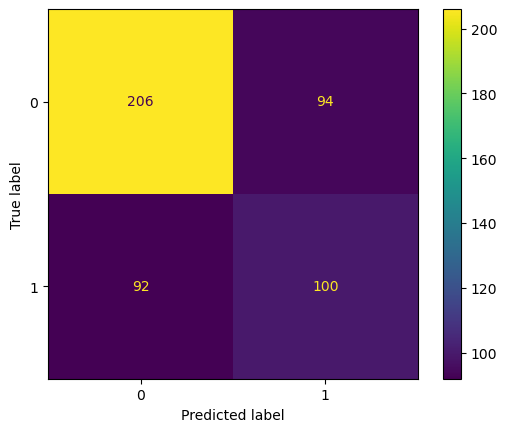

In [26]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [27]:
print(classification_report(y_test,
                        y_pred,
                        target_names = ["non-potable (0)", "potable (1)"]))

                 precision    recall  f1-score   support

non-potable (0)       0.69      0.69      0.69       300
    potable (1)       0.52      0.52      0.52       192

       accuracy                           0.62       492
      macro avg       0.60      0.60      0.60       492
   weighted avg       0.62      0.62      0.62       492



Model has accuracy of 0.62, which definitely still needs improvement

### **8. Dump Production Model to Pickle**

In [28]:
utils.pickle_dump(model, config["production_model_path"])